In [73]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import fastf1
import fastf1.plotting
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec
import os

In [74]:
# Check if the subfolder exists
if not os.path.exists(os.getenv('LOCALAPPDATA') + "/pip/cache/fastF1"):
  # Create the subfolder
  os.makedirs(os.getenv('LOCALAPPDATA') + "/pip/cache/fastF1")

fastf1.Cache.enable_cache(os.getenv('LOCALAPPDATA') + "/pip/cache/fastF1")

In [75]:
tel_data = []
event_names = []
driver_names = []
lap_numbers = []

df = pd.read_excel("./files/Races_cleaned.xlsx",index_col=0)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
session     WARNING 	Request for URL https://ergast.com/api/f1/2022/1/results.json failed; using cached response
Traceback (most recent call last):
  File "c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\connection.py", line 95, in create_connection
    raise err
  File "c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    sock.connect(sa)
TimeoutError: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond

During handling of the above excep

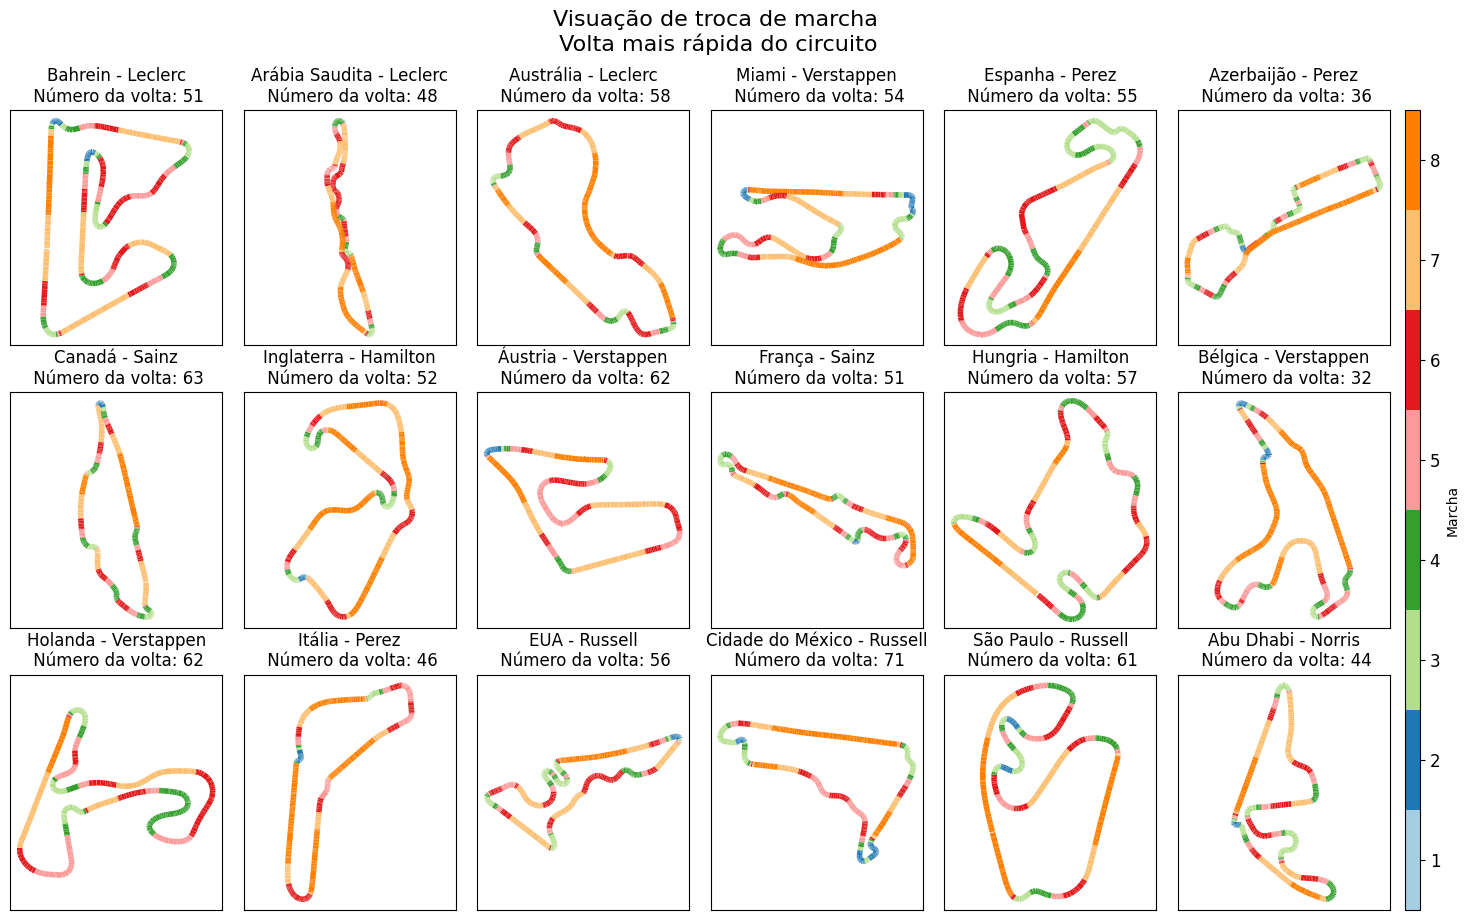

In [77]:
# Load telemetry data for 18 sessions
for event in df['EventName'].unique():
    session = fastf1.get_session(2022, event, 'R')
    session.load()
    
    lap = session.laps.pick_fastest()
    tel = lap.get_telemetry()
    lap.Driver
    tel['EventName'] = event 
    tel['DriverNumber']  = int(lap.DriverNumber)
    tel = pd.merge(tel,pd.DataFrame(df[['EventName','PlaceBrazilianPortuguese','DriverNumber','LastName']]),on=['EventName','DriverNumber'],how = 'left')
    
    # Store telemetry data in lists
    tel_data.append(tel)

    # Store event name
    event_names.append(tel['PlaceBrazilianPortuguese'].unique()[0])
    driver_names.append(tel['LastName'].unique()[0])
    lap_numbers.append(lap['LapNumber'])

# Create figure with 2 rows and 2 columns of subplots
fig, ax = plt.subplots(3, 6, figsize=(15, 10))

# Iterate over telemetry data
for i in range(18):
    #lap = lap_data[i]
    tel = tel_data[i]
    
    # Extract position and gear change data for lap
    x = np.array(tel['X'].values)
    y = np.array(tel['Y'].values)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    gear = tel['nGear'].to_numpy().astype(float)

    # Create LineCollection object for lap
    cmap = cm.get_cmap('Paired')
    lc = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
    lc.set_array(gear)
    lc.set_linewidth(4)
    
    # Add LineCollection object to subplot
    row = i // 6
    col = i % 6
    ax[row, col].add_collection(lc)
    ax[row, col].axis('equal')
    ax[row, col].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    
    # Set title for subplot
    ax[row, col].set_title(event_names[i] + " - " + driver_names[i] +"\n Número da volta: " + str(int(lap_numbers[i])), fontsize=12)
    

# Adjust layout of title and colorbar
plt.subplots_adjust(top = 0.9, bottom = 0.1, left = 0.03, right = 0.95, hspace = 0.2, wspace = 0.1)
title = plt.suptitle(
    f"Visuação de troca de marcha\n Volta mais rápida do circuito",
    y = 1,
    fontsize = 16
)

# Create colorbar with height equal to the number of rows in the subplots
cbar_ax = fig.add_axes([0.96, 0.1, 0.01, 0.8])
cbar = plt.colorbar(mappable=lc, cax=cbar_ax, label="Marcha", boundaries=np.arange(1, 10))
cbar.set_ticks(np.arange(1.5, 9.5))
cbar.set_ticklabels(np.arange(1, 9))
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize = 12)

plt.show()
